In [ ]:
results_file = "data/eval/results.json"
score = "bleu1"
ignore = {
    "task": None,
    "strategy": ["regex"],
    "msid": None,
    "figure_label": None,
    "run": None,
}

In [ ]:
# Import required libraries
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import os
from pathlib import Path


In [ ]:
!pip install -U kaleido


In [ ]:
results_file = "data/eval/results.json"
score = "bleu1"
ignore = {
    "task": None,
    "strategy": ["regex"],
    "msid": None,
    "figure_label": None,
    "run": None,
}

In [ ]:
# Parameters
results_file = "/app/data/eval/2025-01-21_20-07-36/results.json"

# Define color palette
PALETTE = {
    "primary_yellow": "#F2B80E",  # Primary
    "primary_black":  "#222222",  # Primary
    "secondary_red":  "#C53B2E",  # Secondary
    "secondary_orange": "#E1812B",# Secondary
    "secondary_green": "#94AF1F", # Secondary
    "tertiary_blue":   "#449EAF", # Tertiary
    "tertiary_purple": "#3D2D81", # Tertiary
    "tertiary_teal":   "#43806E", # Tertiary
    "tertiary_magenta":"#8E2D64"  # Tertiary
}

# Import required libraries and setup kaleido for PDF export
import plotly.io as pio
pio.kaleido.scope.default_format = "pdf"

# Create figures directory
figures_dir = Path("./figures")
figures_dir.mkdir(exist_ok=True)

def ensure_figures_dir():
    """Create figures directory if it doesn't exist."""
    figures_dir = Path("./figures")
    figures_dir.mkdir(exist_ok=True)
    return figures_dir


In [ ]:
import pandas as pd

df = pd.read_json(results_file)

# remove runs in ignore
for k, v in ignore.items():
    if v is not None:
        df = df[~df[k].isin(v)]

# run is a number, but should be considered a category
df = df.assign(run=df.run.astype('category'))

In [1]:
def get_score_column(task: str) -> str:
    """Get the appropriate score column for each task."""
    if task == 'panel_source_assignment':
        return 'panel_source_manuscript_accuracy'
    elif task == 'extract_data_sources':
        return 'data_source_accuracy'
    else:
        return 'bleu1'



## Top-line stats

In [ ]:
df.groupby(["task", "strategy"])[[score]].describe()

In [ ]:
df[df["task"]=="panel_source_assignment"].groupby(["task", "strategy"])[["panel_source_manuscript_accuracy"]].describe()

## Graphs

In [ ]:
import plotly.express as px

def add_threshold(df, fig, axis="y"):
    score_threshold = df[f"{score}_threshold"].iloc[0].round(2)
    kwargs = dict(
        line_dash="dash",
        line_color="green",
        opacity=0.5,
        annotation_text=f"threshold: {score_threshold}",
        annotation_position="top left",
    )
    if axis == "y":
        fig.add_hline(y=score_threshold, **kwargs)
    else:
        fig.add_vline(x=score_threshold, **kwargs)

def hist_score(df, interval_width=0.01, **kwargs):
    groupby = ["task", "strategy"]
    x_start = 0 - interval_width
    x_end = 1 + interval_width
    y_start = -1
    y_end = df.groupby(groupby).count().max().max() + 1
    fig = px.histogram(
        df,
        x=score,
        range_x=[x_start, x_end],
        range_y=[y_start, y_end],
        facet_col="task",
        facet_row="strategy",
        width=900,
        height=100 + 250 * n_strategies,
        **kwargs,
    )
    fig.update_traces(
        xbins=dict( # bins used for histogram
            start=x_start,
            end=x_end,
            size=interval_width,
        )
    )
    fig.update_layout(bargap=0.2)
    add_threshold(df, fig, axis="x")
    return fig

def scatter_score(df, **kwargs):
    fig = px.scatter(
        df,
        x="msid",
        y=score,
        facet_col="task",
        facet_row="strategy",
        color="run",
        height=100 + 250 * n_strategies,
        width=900,
        **kwargs,
    )
    fig.update_traces(marker_size=10)
    fig.update_layout(scattermode="group", scattergap=0.9)
    add_threshold(df, fig)
    return fig

def plot_std(df, groupby, **kwargs):
    df_std = (
        df.groupby(groupby)
        [score].std()
        .reset_index()
        .sort_values(groupby)
        .rename(columns={score: f"{score}_std"})
    )
    fig = px.scatter(
        df_std,
        x="msid",
        y=f"{score}_std",
        facet_col="task",
        facet_row="strategy",
        height=100 + 250 * n_strategies,
        width=900,
        **kwargs,
    )
    return fig

In [ ]:
for task_df in [legends, labels]:
    if task_df.empty:
        continue
    hist_score(task_df).show()
    scatter_score(task_df).show()
    plot_std(task_df, groupby=["task", "strategy", "msid"]).show()

In [ ]:
for task_df in [titles, captions]:
    if task_df.empty:
        continue
    hist_score(task_df).show()
    scatter_score(
        task_df,
        symbol="figure_label",
    ).show()
    plot_std(
        task_df,
        groupby=["task", "strategy", "msid", "figure_label"],
        color="figure_label",
        symbol="figure_label",
    ).show()

## Run details

## Run details

In [ ]:
import difflib
import html
from IPython.display import display, HTML

def inline_diff(a, b):
    matcher = difflib.SequenceMatcher(None, a, b)
    def process_tag(tag, i1, i2, j1, j2):
        a_text = html.escape(a[i1:i2])
        b_text = html.escape(b[j1:j2])
        if tag == 'delete':
            return '<del>' + a_text + '</del>'
        if tag == 'equal':
            return a_text
        if tag == 'insert':
            return '<ins>' + b_text + '</ins>'
        if tag == 'replace':
            # combine as delete + insert
            return '<del>' + a_text + '</del><ins>' + b_text + '</ins>'
        assert False, "Unknown tag %r"%tag
    return ''.join(process_tag(*t) for t in matcher.get_opcodes())

def display_diff_(row):
    diff_css = """
    <style>
    ins {background-color: #588a41;}  // light green
    del {background-color: #ffaaaa;}  // light red
    repl {background-color: #bb99ff;} // light purple
    table tr > * { width: 50%; }
    table tr > td { vertical-align: top; text-align: left; }
    </style>
    """

    # run_name = (
    #     f"{row.task} - {row.strategy} - {row.msid} - {row.run}"
    #     if row.task == "extract_figure_caption"
    #     else f"{row.task} - {row.strategy} - {row.msid} - {row.figure_label} - {row.run}"
    # )
    # header = f"<h3>{run_name}</h3>"
    section_fn = lambda title, content: f"<h4>{title}</h4><p>{content}</p>"
    # scores = section_fn("Scores", f"bleu1: {row.bleu1[0]:.2f}}")

    comparison = f"""
        <table>
            <thead>
                <tr>
                    <th>Expected</th>
                    <th>Actual</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td>{html.escape(row.head(1)["expected"].values[0])}</td>
                    <td>{html.escape(row.head(1)["actual"].values[0])}</td>
                </tr>
            </tbody>
        </table>
    """
    diff = section_fn("Diff", inline_diff(row.head(1)["expected"].values[0], row.head(1)["actual"].values[0]) + comparison)
    input_text = section_fn("Input", row.input)

    # display(HTML(diff_css + header + scores + diff + input_text))
    display(HTML(diff_css + diff + input_text))


In [ ]:
df["task"].unique()

In [ ]:
df_bad_figure_legends = df[(df["task"]=="extract_figure_legends") & (df["bleu1"]<0.95)]
df_bad_labels = df[(df["task"]=="extract_figures") & (df["bleu1"]<0.95)]
df_bad_titles = df[(df["task"]=="extract_figure_title") & (df["bleu1"]<0.95)]
df_bad_caption = df[(df["task"]=="extract_figure_caption") & (df["bleu1"]<0.95)]


## Examples of bad detection of figure section

In [ ]:
display_diff_(df_bad_figure_legends.sample()) if len(df_bad_figure_legends) > 0 else print("No bad figure legends")

## Examples of bad detection of figure label

In [ ]:
display_diff_(df_bad_labels.sample()) if len(df_bad_labels) > 0 else print("No bad figure labels")

## Examples of bad figure titles

In [ ]:
display_diff_(df_bad_titles.sample()) if len(df_bad_titles) > 0 else print("No bad figure titles")

## Examples of bad figure captions

In [ ]:
display_diff_(df_bad_caption.sample()) if len(df_bad_caption) > 0 else print("No bad figure captions")

# Single visualizations where we could have a better intuition of the results

In [ ]:
df.columns

In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

# Create new column for model type (GPT vs Claude)
df['model_type'] = df['strategy'].apply(lambda x: 'GPT' if 'gpt' in x.lower() else 'Claude' if 'claude' in x.lower() else 'Other')

# Define consistent colors and bins
colors = {'GPT': '#2E91E5', 'Claude': '#E15F99'}  # Blue for GPT, Pink for Claude

# Create uniform bins from 0 to 1
bin_size = 0.025  # This creates 20 bins of size 0.05 each
bins = list(np.arange(0, 1.1, bin_size))  # Adding .05 to include 1.0

# Create distribution plots per task
tasks = df['task'].unique()
fig_dist = make_subplots(
    rows=len(tasks), 
    cols=1,
    subplot_titles=[task.replace('_', ' ').title() for task in tasks],
    vertical_spacing=0.1
)

for i, task in enumerate(tasks, 1):
    task_data = df[df['model_type'].isin(['GPT', 'Claude']) & (df['task'] == task)]
    
    for model in ['GPT', 'Claude']:
        model_data = task_data[task_data['model_type'] == model]['bleu1']
        
        # Create histogram trace with consistent bins
        fig_dist.add_trace(
            go.Histogram(
                x=model_data,
                name=model,
                histfunc='count',
                xbins=dict(
                    start=0,
                    end=1.1,
                    size=bin_size
                ),
                hovertemplate="Score Range: %{x}<br>Count: %{y}<extra></extra>",
                cumulative_enabled=False,
                showlegend=i==1,  # Only show legend for first subplot
                opacity=0.7,
                marker_color=colors[model],
                marker_line_width=1,
                marker_line_color='white',
                histnorm='probability'
            ),
            row=i, 
            col=1
        )

# Update layout after creating all subplots
fig_dist.update_layout(
    title='Score Distribution by Task: GPT vs Claude',
    width=900,
    height=300*len(tasks),
    barmode='overlay',
    bargap=0.1
)

# Update each subplot's axes
for i in range(len(tasks)):
    fig_dist.update_yaxes(title_text="Probability", row=i+1, col=1)
    fig_dist.update_xaxes(
        title_text="BLEU-1 Score", 
        range=[0, 1.02],
        dtick=0.1,  # Add gridlines every 0.1
        row=i+1, 
        col=1
    )

fig_dist.show()

# Bar plot with error bars
model_stats = df[df['model_type'].isin(['GPT', 'Claude'])].groupby(['task', 'model_type'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

# Bar plot with error bars - using the same colors
fig_bar = px.bar(
    model_stats,
    x='task',
    y='mean',
    error_y='std',
    color='model_type',
    barmode='group',
    title='Average Performance by Task: GPT vs Claude',
    labels={
        'task': 'Task',
        'mean': 'Average BLEU-1 Score',
        'model_type': 'Model Type'
    },
    color_discrete_map=colors
)

fig_bar.update_layout(
    yaxis_range=[0, 1],
    width=900,
    height=500,
    xaxis_tickangle=-45
)
fig_bar.show()

# Print summary statistics and t-tests
print("\nSummary Statistics by Task:")
print(model_stats.round(3))

print("\nt-test results by task:")
for task in tasks:
    task_data = df[df['task'] == task]
    gpt_scores = task_data[task_data['model_type'] == 'GPT']['bleu1']
    claude_scores = task_data[task_data['model_type'] == 'Claude']['bleu1']
    t_stat, p_value = stats.ttest_ind(gpt_scores, claude_scores)
    print(f"\nTask: {task}")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3e}")

In [ ]:
# First, let's identify all GPT and Claude variations
gpt_strategies = df[df['strategy'].str.contains('gpt', case=False)]['strategy'].unique()
claude_strategies = df[df['strategy'].str.contains('claude', case=False)]['strategy'].unique()

# Calculate stats for GPT variations
gpt_stats = df[df['strategy'].isin(gpt_strategies)].groupby(['task', 'strategy'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

# Calculate stats for Claude variations
claude_stats = df[df['strategy'].isin(claude_strategies)].groupby(['task', 'strategy'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

# Create bar plot for GPT variations
fig_gpt = px.bar(
    gpt_stats,
    x='task',
    y='mean',
    error_y='std',
    color='strategy',
    barmode='group',
    title='Performance by Task: GPT Variations',
    labels={
        'task': 'Task',
        'mean': 'Average BLEU-1 Score',
        'strategy': 'Strategy'
    },
    color_discrete_sequence=px.colors.qualitative.Set1  # Use a consistent color palette
)

fig_gpt.update_layout(
    yaxis_range=[0, 1.2],
    width=900,
    height=500,
    xaxis_tickangle=-45,
    showlegend=True,
    legend_title_text='GPT Variations'
)
fig_gpt.show()

# Create bar plot for Claude variations
fig_claude = px.bar(
    claude_stats,
    x='task',
    y='mean',
    error_y='std',
    color='strategy',
    barmode='group',
    title='Performance by Task: Claude Variations',
    labels={
        'task': 'Task',
        'mean': 'Average BLEU-1 Score',
        'strategy': 'Strategy'
    },
    color_discrete_sequence=px.colors.qualitative.Set2  # Use a different color palette for Claude
)

fig_claude.update_layout(
    yaxis_range=[0, 1.2],
    width=900,
    height=500,
    xaxis_tickangle=-45,
    showlegend=True,
    legend_title_text='Claude Variations'
)
fig_claude.show()

# Print summary statistics
print("\nSummary Statistics for GPT Variations:")
print(gpt_stats.round(3))
print("\nSummary Statistics for Claude Variations:")
print(claude_stats.round(3))

In [ ]:
# Create new column for model type (GPT vs Claude)
df['model_type'] = df['strategy'].apply(lambda x: 'GPT' if 'gpt' in x.lower() else 'Claude' if 'claude' in x.lower() else 'Other')

# Define consistent colors
colors = {'GPT': '#2E91E5', 'Claude': '#E15F99'}

# Create box plots per manuscript for each task
tasks = df['task'].unique()
fig_boxes = make_subplots(
    rows=len(tasks), 
    cols=1,
    subplot_titles=[task.replace('_', ' ').title() for task in tasks],
    vertical_spacing=0.1
)

for i, task in enumerate(tasks, 1):
    task_data = df[df['model_type'].isin(['GPT', 'Claude']) & (df['task'] == task)]
    
    for model in ['GPT', 'Claude']:
        model_data = task_data[task_data['model_type'] == model]
        
        fig_boxes.add_trace(
            go.Box(
                x=model_data['msid'],
                y=model_data['bleu1'],
                name=model,
                boxpoints='outliers',
                marker_color=colors[model],
                showlegend=i==1,
                hovertemplate="Manuscript: %{x}<br>Score: %{y}<extra></extra>"
            ),
            row=i, 
            col=1
        )

fig_boxes.update_layout(
    title='Score Distribution by Task and Manuscript: GPT vs Claude',
    width=1200,
    height=300*len(tasks),
    boxmode='group'
)

# Update axes for each subplot
for i in range(len(tasks)):
    is_last_plot = (i == len(tasks) - 1)  # Check if this is the last subplot
    
    # Update y-axis
    fig_boxes.update_yaxes(
        title_text="BLEU-1 Score" if i == len(tasks)//2 else None,  # Y-axis title in middle subplot
        range=[0, 1.1],
        dtick=0.1,
        row=i+1, 
        col=1
    )
    
    # Update x-axis
    fig_boxes.update_xaxes(
        title_text="Manuscript ID" if is_last_plot else None,  # X-axis title only on last subplot
        tickangle=-45,
        showticklabels=is_last_plot,  # Show tick labels only on last subplot
        row=i+1,
        col=1
    )

fig_boxes.show()

# Overview boxplot remains the same
fig_task_overview = go.Figure()

for model in ['GPT', 'Claude']:
    model_data = df[df['model_type'] == model]
    
    fig_task_overview.add_trace(
        go.Box(
            x=model_data['task'],
            y=model_data['bleu1'],
            name=model,
            boxpoints='outliers',
            marker_color=colors[model],
            hovertemplate="Task: %{x}<br>Score: %{y}<extra></extra>"
        )
    )

fig_task_overview.update_layout(
    title='Overall Score Distribution by Task: GPT vs Claude',
    width=900,
    height=500,
    boxmode='group',
    yaxis=dict(
        title="BLEU-1 Score",
        range=[0, 1.1],
        dtick=0.1
    ),
    xaxis=dict(
        title="Task",
        tickangle=-45
    )
)

fig_task_overview.show()

In [ ]:
# First, let's get our distributions per manuscript
# Create distribution plots per manuscript
manuscripts = df['msid'].unique()
fig_dist = make_subplots(
    rows=len(manuscripts), 
    cols=1,
    subplot_titles=[f"Manuscript {msid}" for msid in manuscripts],
    vertical_spacing=0.1
)

# Define consistent colors and bins
colors = {'GPT': '#2E91E5', 'Claude': '#E15F99'}
bin_size = 0.05
bins = list(np.arange(0, 1.05, bin_size))

for i, msid in enumerate(manuscripts, 1):
    manuscript_data = df[df['model_type'].isin(['GPT', 'Claude']) & (df['msid'] == msid)]
    
    for model in ['GPT', 'Claude']:
        model_data = manuscript_data[manuscript_data['model_type'] == model]['bleu1']
        
        fig_dist.add_trace(
            go.Histogram(
                x=model_data,
                name=model,
                histfunc='count',
                xbins=dict(
                    start=0,
                    end=1,
                    size=bin_size
                ),
                hovertemplate="Score Range: %{x}<br>Count: %{y}<extra></extra>",
                cumulative_enabled=False,
                showlegend=i==1,
                opacity=0.7,
                marker_color=colors[model],
                marker_line_width=1,
                marker_line_color='white',
                histnorm='probability'
            ),
            row=i, 
            col=1
        )

fig_dist.update_layout(
    title='Score Distribution by Manuscript: GPT vs Claude',
    width=900,
    height=300*len(manuscripts),
    barmode='overlay',
    bargap=0.1
)

for i in range(len(manuscripts)):
    fig_dist.update_yaxes(title_text="Probability", row=i+1, col=1)
    fig_dist.update_xaxes(
        title_text="BLEU-1 Score", 
        range=[0, 1.1],
        dtick=0.1,
        row=i+1, 
        col=1
    )

fig_dist.show()

# Now let's analyze GPT and Claude variations per manuscript
# For GPT variations
gpt_manuscript_stats = df[df['strategy'].isin(gpt_strategies)].groupby(['msid', 'strategy'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

fig_gpt_manuscript = px.bar(
    gpt_manuscript_stats,
    x='msid',
    y='mean',
    error_y='std',
    color='strategy',
    barmode='group',
    title='Performance by Manuscript: GPT Variations',
    labels={
        'msid': 'Manuscript ID',
        'mean': 'Average BLEU-1 Score',
        'strategy': 'Strategy'
    },
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig_gpt_manuscript.update_layout(
    yaxis_range=[0, 1.1],
    width=900,
    height=500,
    xaxis_tickangle=-45,
    showlegend=True,
    legend_title_text='GPT Variations'
)
fig_gpt_manuscript.show()

# For Claude variations
claude_manuscript_stats = df[df['strategy'].isin(claude_strategies)].groupby(['msid', 'strategy'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

fig_claude_manuscript = px.bar(
    claude_manuscript_stats,
    x='msid',
    y='mean',
    error_y='std',
    color='strategy',
    barmode='group',
    title='Performance by Manuscript: Claude Variations',
    labels={
        'msid': 'Manuscript ID',
        'mean': 'Average BLEU-1 Score',
        'strategy': 'Strategy'
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig_claude_manuscript.update_layout(
    yaxis_range=[0, 1.1],
    width=900,
    height=500,
    xaxis_tickangle=-45,
    showlegend=True,
    legend_title_text='Claude Variations'
)
fig_claude_manuscript.show()

# Let's also analyze performance per manuscript and task
manuscript_task_stats = df[df['model_type'].isin(['GPT', 'Claude'])].groupby(['msid', 'task', 'model_type'])['bleu1'].agg([
    'mean',
    'std',
    'count'
]).reset_index()

fig_task_manuscript = px.bar(
    manuscript_task_stats,
    x='msid',
    y='mean',
    error_y='std',
    color='model_type',
    facet_row='task',
    barmode='group',
    title='Performance by Manuscript and Task: GPT vs Claude',
    labels={
        'msid': 'Manuscript ID',
        'mean': 'Average BLEU-1 Score',
        'model_type': 'Model Type'
    },
    color_discrete_map=colors
)

fig_task_manuscript.update_layout(
    yaxis_range=[0, 1.1],
    width=900,
    height=200*len(df['task'].unique()),
    showlegend=True
)
fig_task_manuscript.show()

# Print summary statistics for potentially problematic manuscripts
print("\nIdentifying potentially problematic manuscripts:")
for msid in manuscripts:
    manuscript_data = df[df['msid'] == msid]
    mean_score = manuscript_data['bleu1'].mean()
    std_score = manuscript_data['bleu1'].std()
    
    if mean_score < df['bleu1'].mean() - df['bleu1'].std():
        print(f"\nManuscript {msid} shows lower than average performance:")
        print(f"Mean score: {mean_score:.3f}")
        print(f"Std deviation: {std_score:.3f}")
        
        # Show task-specific performance for this manuscript
        task_performance = manuscript_data.groupby('task')['bleu1'].agg(['mean', 'std'])
        print("\nTask-specific performance:")
        print(task_performance.round(3))

# Overal results

## 1. Aggregated by task and comparing different model parametrization

### 1.1 Histograms

In [ ]:
def get_score_column(task: str) -> str:
    """Get the appropriate score column for each task."""
    if task == 'panel_source_assignment':
        return 'panel_source_manuscript_accuracy'
    elif task == 'extract_data_sources':
        return 'data_source_accuracy'
    else:
        return 'bleu1'



In [ ]:
def create_step_histograms(df, tasks, save_pdf=True):
    """Create step histograms for each task showing distribution of scores by strategy."""
    figures = []
    
    # Map strategies to colors
    strategies = df['strategy'].unique()
    strategy_colors = {
        strategy: color for strategy, color in zip(
            strategies, 
            [PALETTE[key] for key in PALETTE.keys()][:len(strategies)]
        )
    }
    
    # Create figures directory if saving PDFs
    if save_pdf:
        figures_dir = Path("./figures")
        figures_dir.mkdir(exist_ok=True)
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for task in tasks:
        # Create new figure
        plt.figure(figsize=(12, 8))
        
        # Get appropriate score column for this task
        score_col = get_score_column(task)
        task_data = df[df['task'] == task]
        
        # Setup histogram bins
        bins = np.linspace(0, 1, 25)  # 24 bins from 0 to 1
        
        # Plot histogram for each strategy
        for strategy in strategies:
            strategy_data = task_data[task_data['strategy'] == strategy][score_col]
            
            plt.hist(strategy_data, 
                    bins=bins,
                    histtype='step',
                    label=strategy,
                    color=strategy_colors[strategy],
                    linewidth=2,
                    density=True,
                    alpha=1.0)
        
        # Customize plot
        plt.title(f'Score Distribution for {task.replace("_", " ").title()}', 
                 fontsize=14, pad=20)
        plt.xlabel('Score', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Strategy', frameon=True)
        
        # Set axis limits
        plt.xlim(-0.05, 1.05)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if requested
        if save_pdf:
            filename = f'histogram_performance_comparison_by_strategy_{task}.pdf'
            plt.savefig(figures_dir / filename, bbox_inches='tight', dpi=300)
        
        figures.append(plt.gcf())
        
    return figures

def calculate_histogram_statistics(df, tasks):
    """Calculate and print basic statistics for histogram data."""
    print("\nHistogram Statistics")
    print("=" * 50)
    
    for task in tasks:
        score_col = get_score_column(task)
        task_data = df[df['task'] == task]
        
        print(f"\nTask: {task} (using {score_col})")
        print("-" * 30)
        
        for strategy in df['strategy'].unique():
            strategy_data = task_data[task_data['strategy'] == strategy][score_col]
            
            print(f"\nStrategy: {strategy}")
            print(f"Mean: {strategy_data.mean():.3f}")
            print(f"Median: {strategy_data.median():.3f}")
            print(f"Std: {strategy_data.std():.3f}")
            print(f"Min: {strategy_data.min():.3f}")
            print(f"Max: {strategy_data.max():.3f}")



Histogram Statistics

Task: extract_figure_legends (using bleu1)
------------------------------

Strategy: gpt-4o_top_p=0.1
Mean: 0.998
Median: 0.998
Std: 0.000
Min: 0.998
Max: 0.999

Strategy: gpt-4o_temp=0.1
Mean: 0.998
Median: 0.998
Std: 0.000
Min: 0.998
Max: 0.999

Task: extract_figure_title (using bleu1)
------------------------------

Strategy: gpt-4o_top_p=0.1
Mean: 0.932
Median: 1.000
Std: 0.171
Min: 0.446
Max: 1.000

Strategy: gpt-4o_temp=0.1
Mean: 0.932
Median: 1.000
Std: 0.171
Min: 0.446
Max: 1.000

Task: extract_figure_caption (using bleu1)
------------------------------

Strategy: gpt-4o_top_p=0.1
Mean: 0.978
Median: 0.979
Std: 0.021
Min: 0.932
Max: 1.000

Strategy: gpt-4o_temp=0.1
Mean: 0.974
Median: 0.971
Std: 0.020
Min: 0.932
Max: 1.000

Task: panel_source_assignment (using panel_source_manuscript_accuracy)
------------------------------

Strategy: gpt-4o_top_p=0.1
Mean: 0.764
Median: 0.750
Std: 0.063
Min: 0.667
Max: 0.833

Strategy: gpt-4o_temp=0.1
Mean: 0.792
Median:

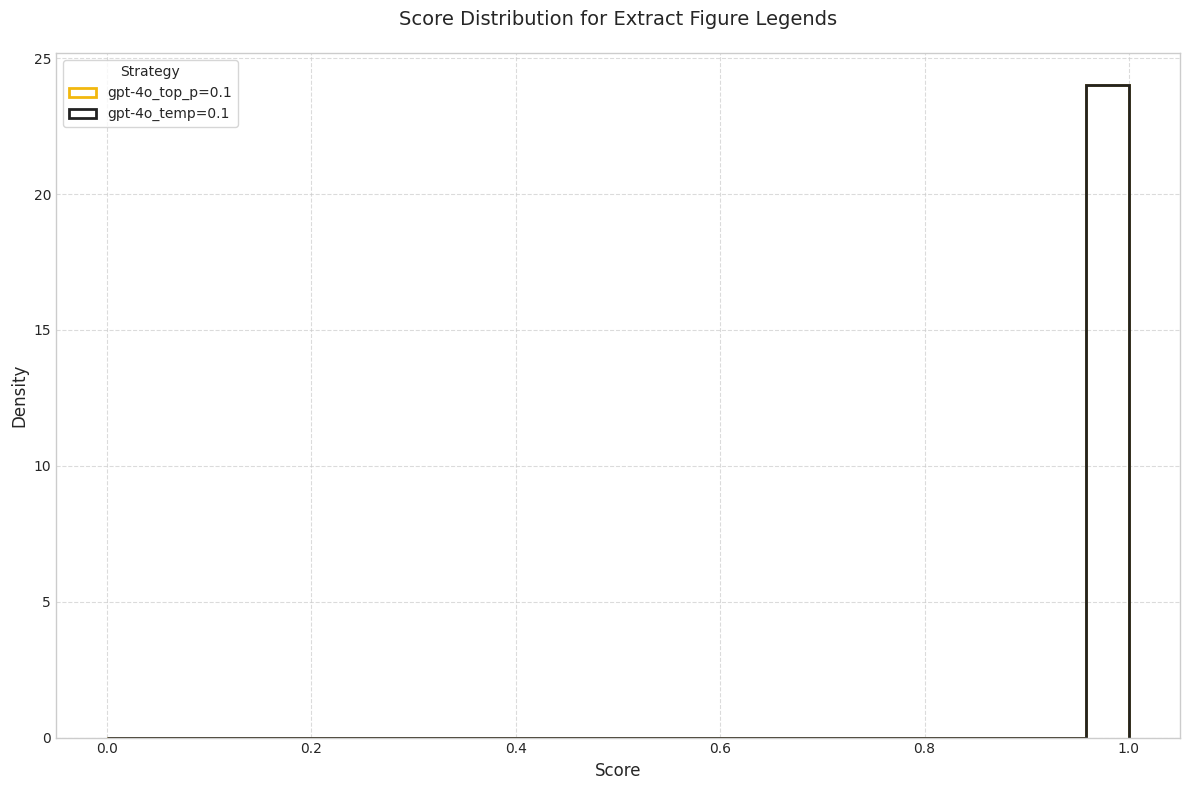

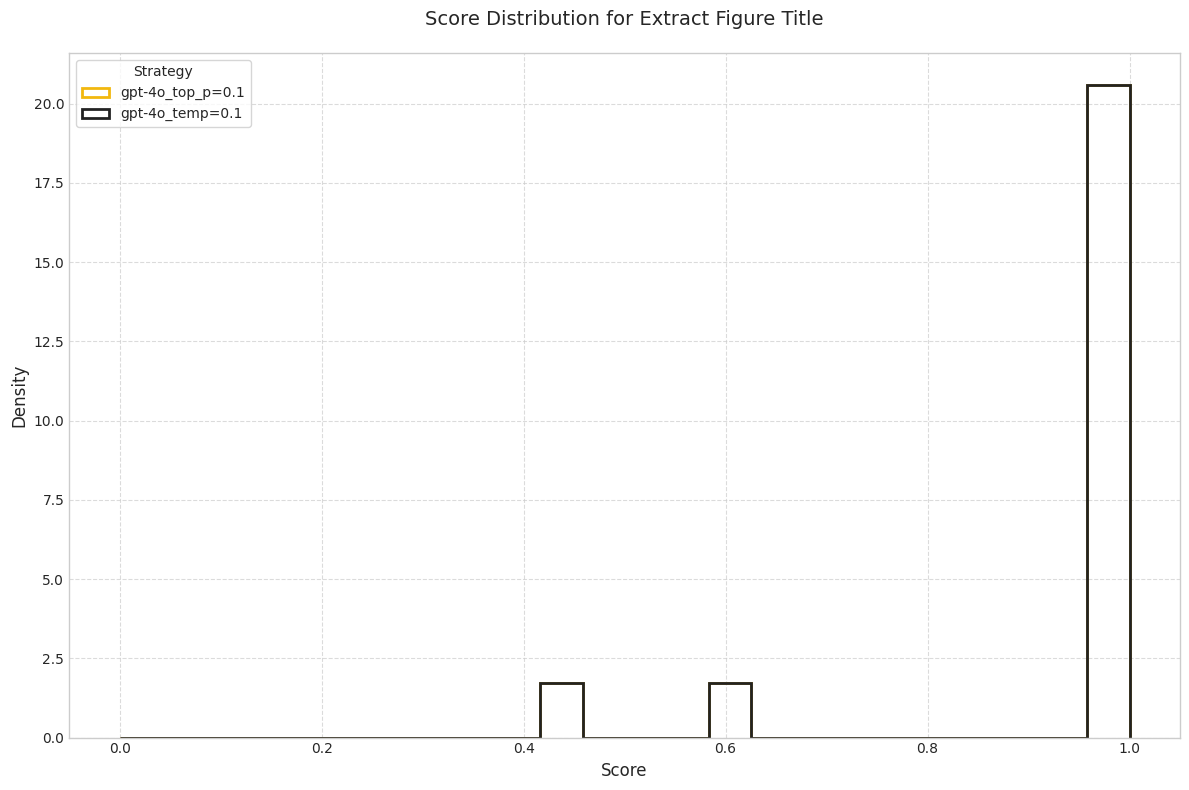

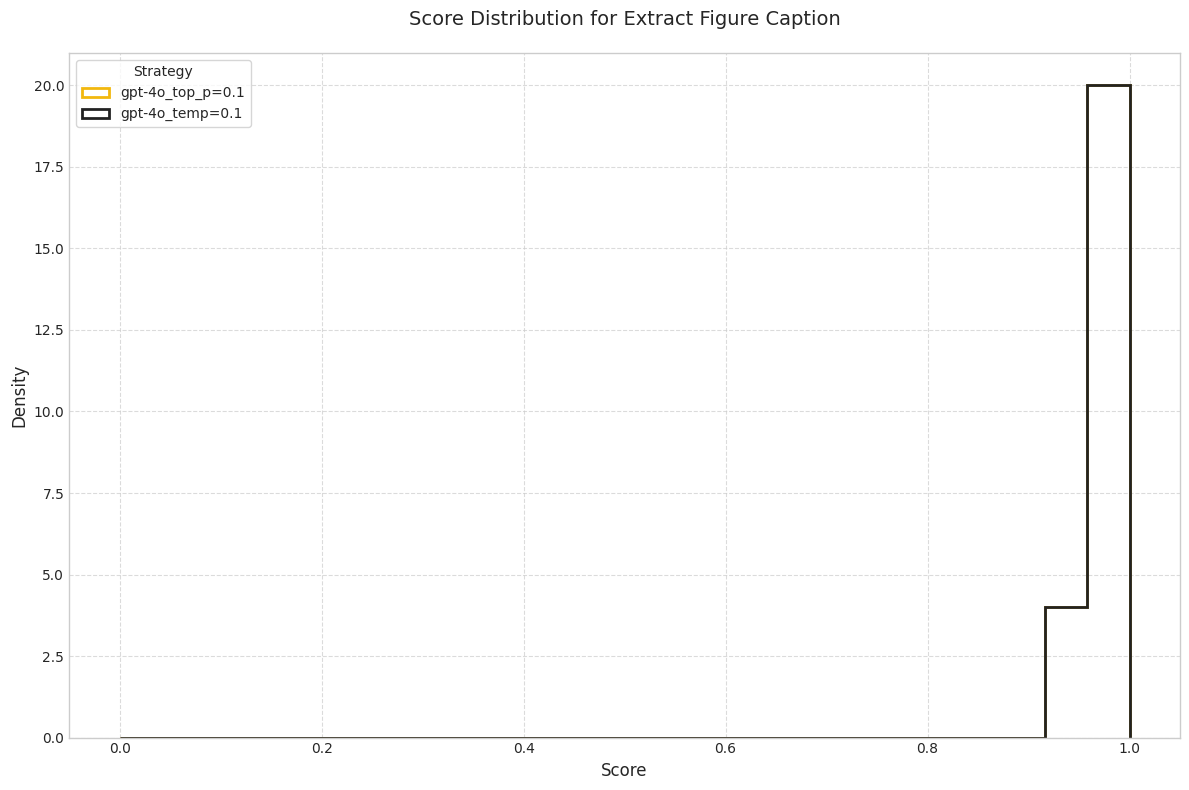

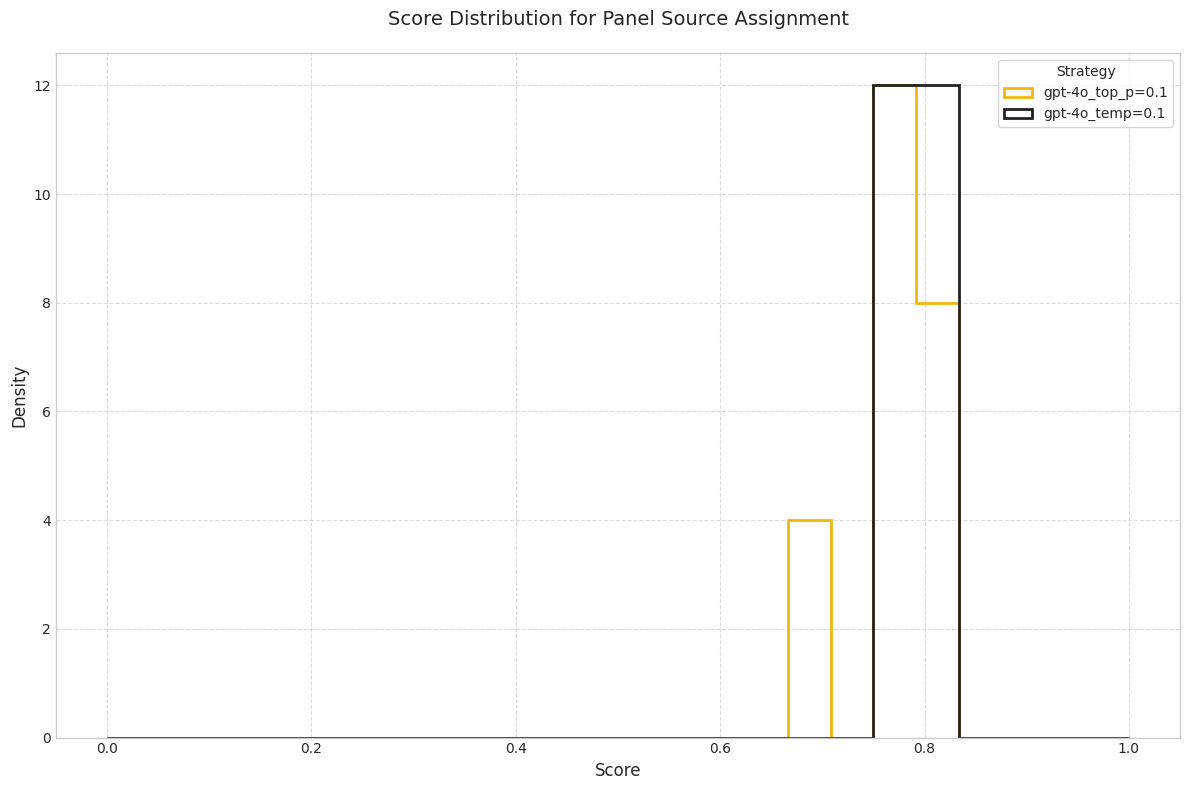

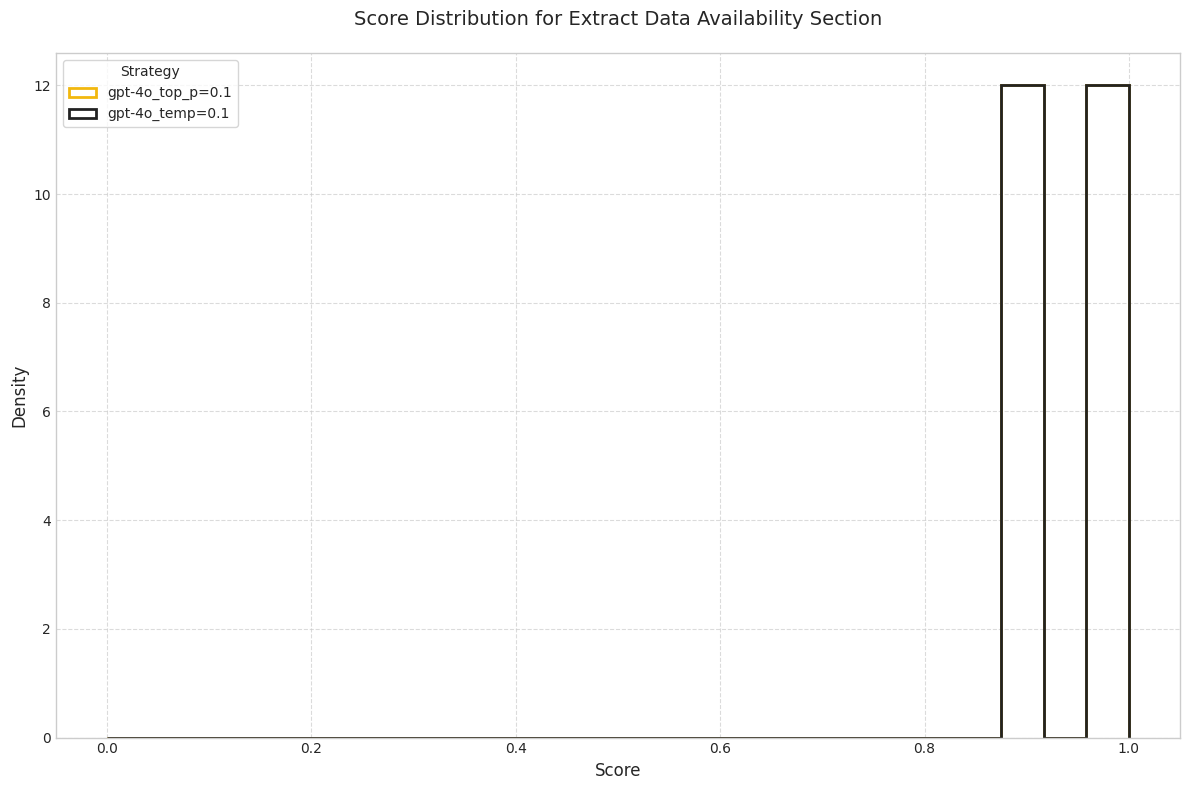

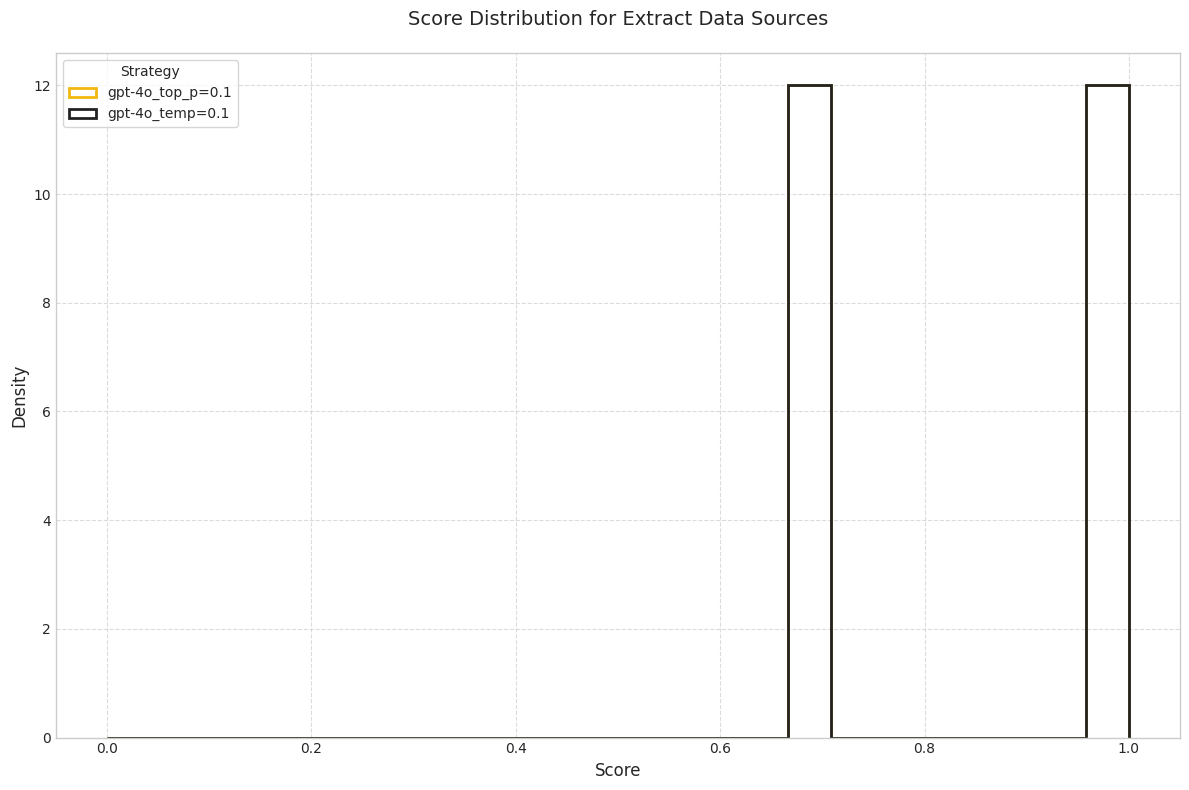

In [ ]:
import matplotlib.pyplot as plt

# Create step histograms
tasks = df['task'].unique()
hist_figures = create_step_histograms(df, tasks, save_pdf=True)

# Show statistical summary
calculate_histogram_statistics(df, tasks)

# Show plots (optional)
plt.show()


## 1.2 Boxplots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def create_boxplots(df, tasks, save_pdf=True):
    """Create box plots for each task showing score distribution by strategy."""
    figures = []
    
    # Map strategies to colors
    strategies = df['strategy'].unique()
    strategy_colors = {
        strategy: color for strategy, color in zip(
            strategies, 
            [PALETTE[key] for key in PALETTE.keys()][:len(strategies)]
        )
    }
    
    # Create figures directory if saving PDFs
    if save_pdf:
        figures_dir = Path("./figures")
        figures_dir.mkdir(exist_ok=True)
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for task in tasks:
        # Create new figure
        plt.figure(figsize=(12, 8))
        
        # Get appropriate score column for this task
        score_col = get_score_column(task)
        task_data = df[df['task'] == task]
        
        # Create list of scores for each strategy
        scores_by_strategy = []
        strategy_labels = []
        for strategy in strategies:
            strategy_data = task_data[task_data['strategy'] == strategy][score_col]
            scores_by_strategy.append(strategy_data.values)
            strategy_labels.append(strategy)
        
        # Create box plot
        bplot = plt.boxplot(scores_by_strategy, 
                           labels=strategy_labels,
                           patch_artist=True,
                           medianprops=dict(color="black", linewidth=1.5),
                           flierprops=dict(marker='o', markersize=5))
        
        # Color boxes
        for patch, strategy in zip(bplot['boxes'], strategy_labels):
            patch.set_facecolor(strategy_colors[strategy])
            patch.set_alpha(0.7)
        
        # Print number of data points per strategy
        print(f"\nTask: {task} (using {score_col})")
        for strategy, scores in zip(strategy_labels, scores_by_strategy):
            print(f"Strategy {strategy}: {len(scores)} data points")
            if len(scores) == 0:
                print("WARNING: No data points for this strategy!")
            else:
                print(f"Value range: {np.min(scores):.3f} to {np.max(scores):.3f}")
        
        # Customize plot
        plt.title(f'Score Distribution for {task.replace("_", " ").title()}', 
                 fontsize=14, pad=20)
        plt.xlabel('Strategy', fontsize=12)
        plt.ylabel(f'{score_col.replace("_", " ").title()}', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Rotate strategy labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Set y-axis limits
        plt.ylim(-0.05, 1.05)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if requested
        if save_pdf:
            filename = f'boxplot_performance_comparison_by_strategy_{task}.pdf'
            plt.savefig(figures_dir / filename, bbox_inches='tight', dpi=300)
        
        figures.append(plt.gcf())
        
    return figures

def print_detailed_statistics(df, tasks):
    """Print detailed statistics for each task and strategy."""
    print("\nDetailed Statistics")
    print("=" * 50)
    
    for task in tasks:
        score_col = get_score_column(task)
        task_data = df[df['task'] == task]
        
        print(f"\nTask: {task} (using {score_col})")
        print("-" * 30)
        
        for strategy in df['strategy'].unique():
            strategy_data = task_data[task_data['strategy'] == strategy][score_col]
            
            print(f"\nStrategy: {strategy}")
            if len(strategy_data) == 0:
                print("No data points!")
                continue
                
            print(f"Number of data points: {len(strategy_data)}")
            print(f"Mean: {strategy_data.mean():.3f}")
            print(f"Median: {strategy_data.median():.3f}")
            print(f"Std: {strategy_data.std():.3f}")
            print(f"Min: {strategy_data.min():.3f}")
            print(f"Max: {strategy_data.max():.3f}")
            print(f"Quartiles:")
            print(f"  Q1 (25%): {strategy_data.quantile(0.25):.3f}")
            print(f"  Q2 (50%): {strategy_data.quantile(0.50):.3f}")
            print(f"  Q3 (75%): {strategy_data.quantile(0.75):.3f}")
            
            # Calculate number of unique values
            n_unique = len(strategy_data.unique())
            print(f"Number of unique values: {n_unique}")
            if n_unique <= 5:  # If few unique values, show them
                print(f"Unique values: {sorted(strategy_data.unique())}")






Task: extract_figure_legends (using bleu1)
Strategy gpt-4o_top_p=0.1: 6 data points
Value range: 0.998 to 0.999
Strategy gpt-4o_temp=0.1: 6 data points
Value range: nan to nan

Task: extract_figure_title (using bleu1)
Strategy gpt-4o_top_p=0.1: 42 data points
Value range: 0.446 to 1.000
Strategy gpt-4o_temp=0.1: 42 data points
Value range: 0.446 to 1.000

Task: extract_figure_caption (using bleu1)
Strategy gpt-4o_top_p=0.1: 84 data points
Value range: 0.932 to 1.000
Strategy gpt-4o_temp=0.1: 84 data points
Value range: 0.932 to 1.000

Task: panel_source_assignment (using panel_source_manuscript_accuracy)
Strategy gpt-4o_top_p=0.1: 6 data points
Value range: 0.667 to 0.833
Strategy gpt-4o_temp=0.1: 6 data points
Value range: 0.750 to 0.833

Task: extract_data_availability_section (using bleu1)
Strategy gpt-4o_top_p=0.1: 6 data points
Value range: 0.887 to 1.000
Strategy gpt-4o_temp=0.1: 6 data points
Value range: 0.887 to 1.000

Task: extract_data_sources (using data_source_accuracy)
S

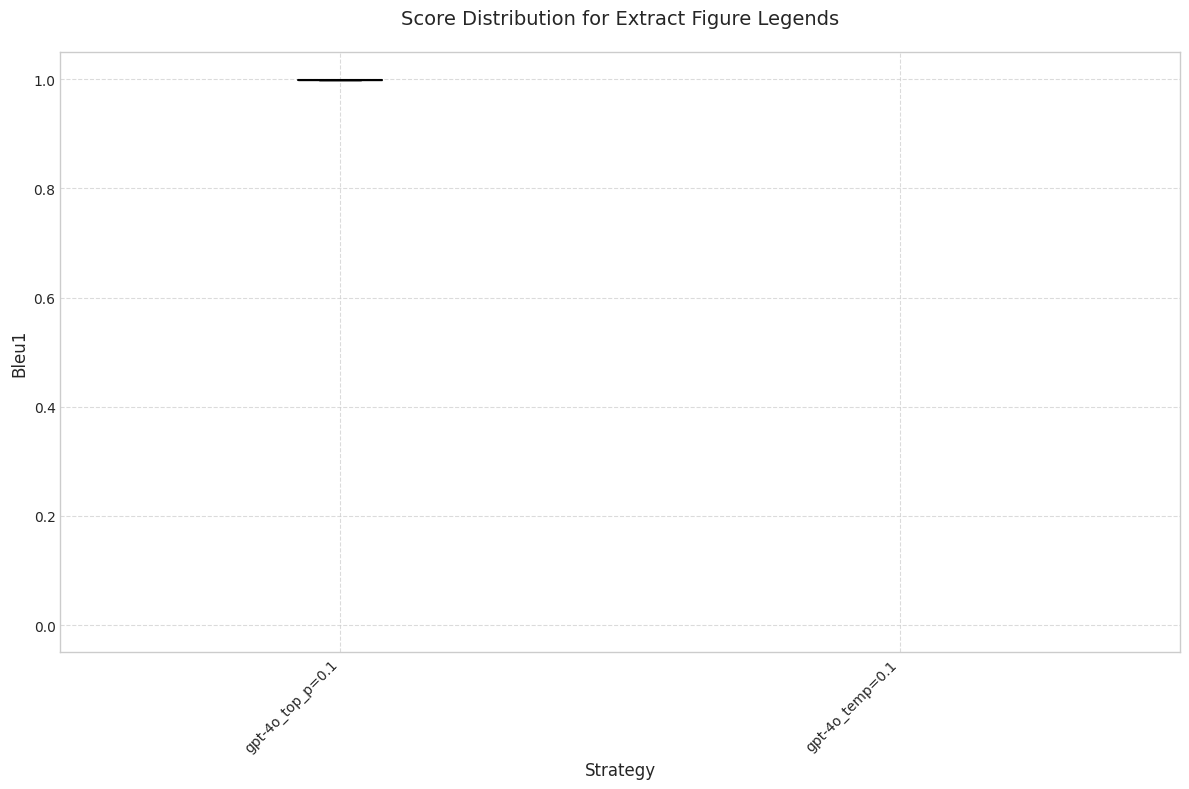

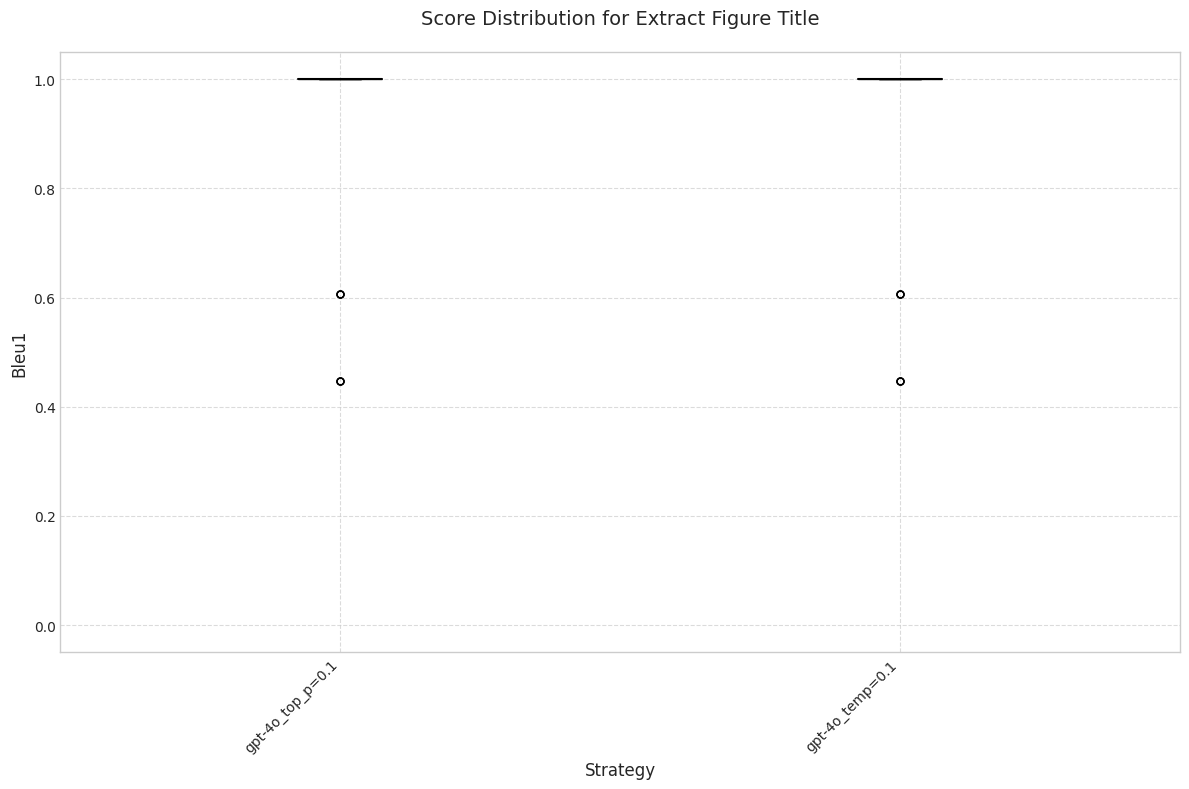

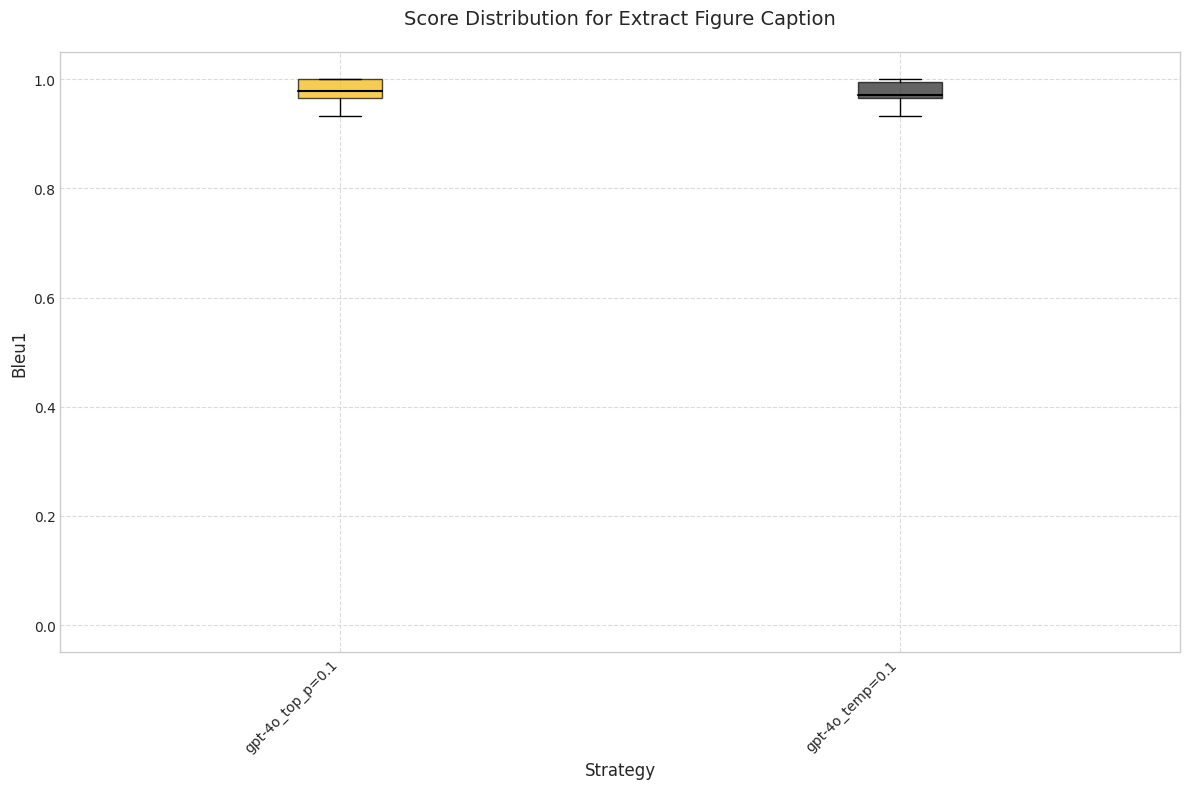

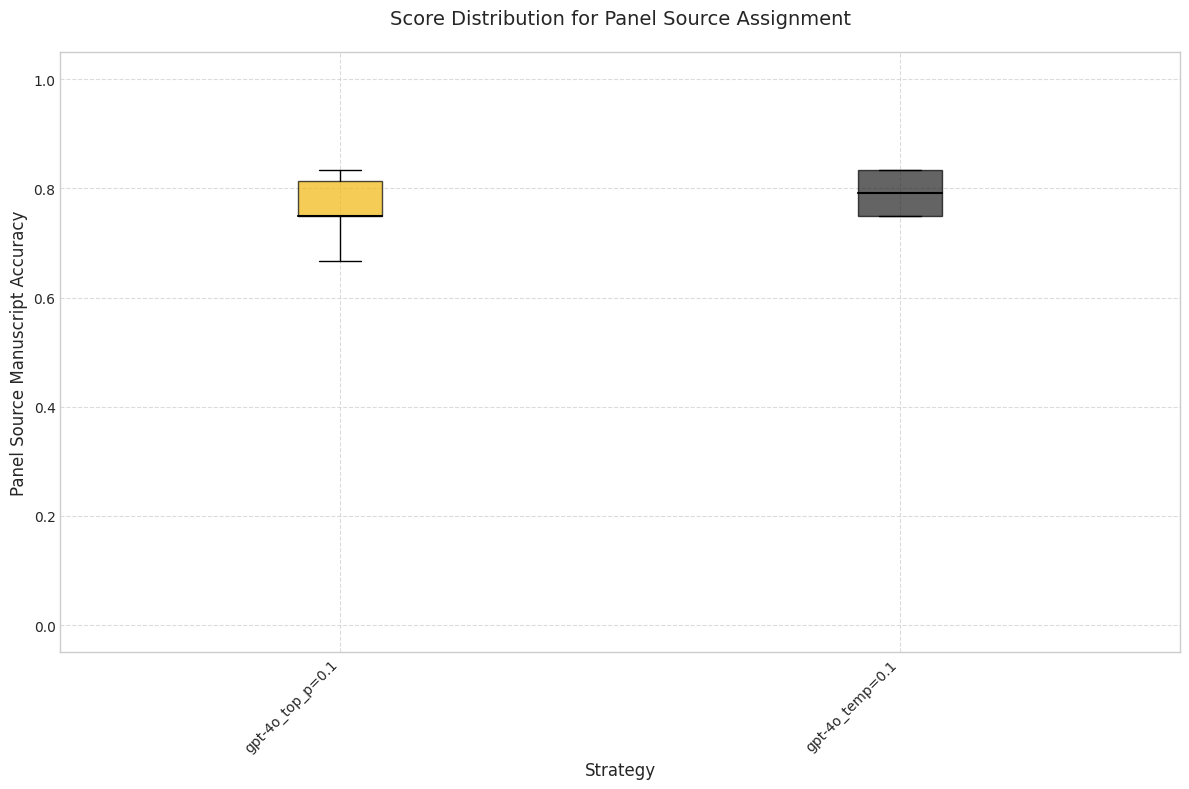

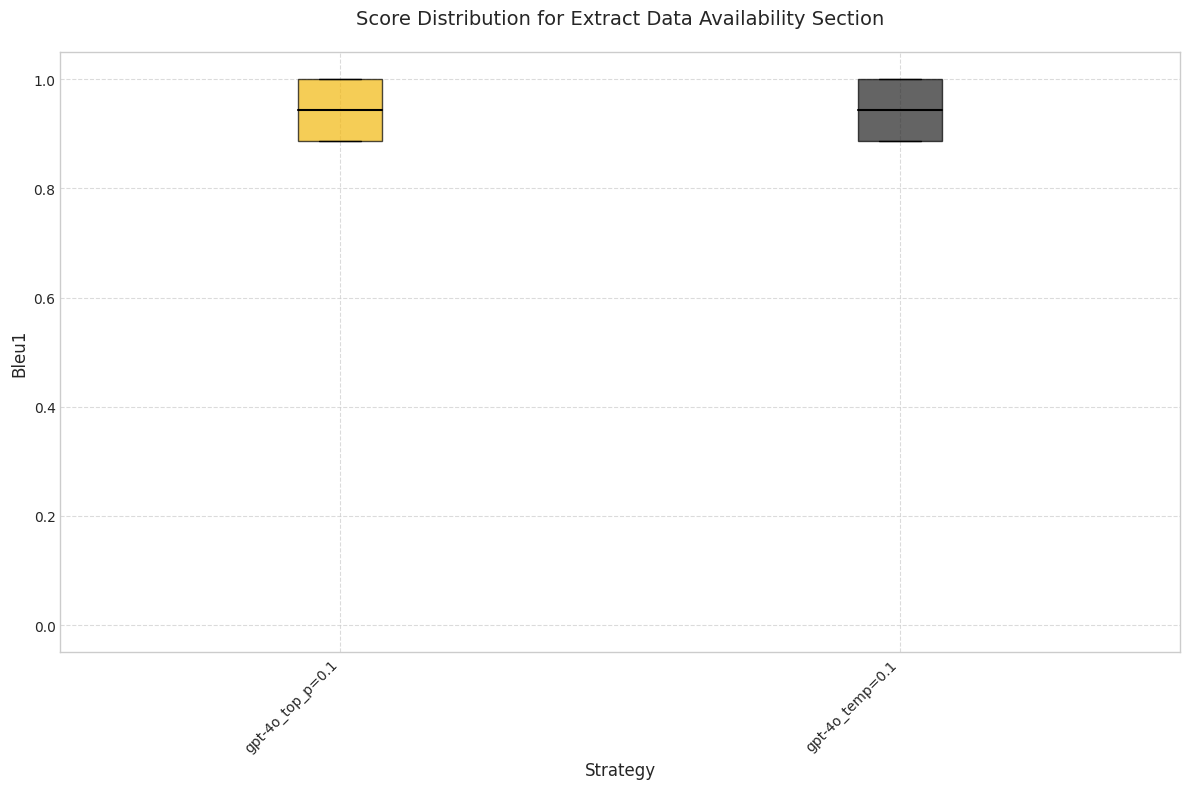

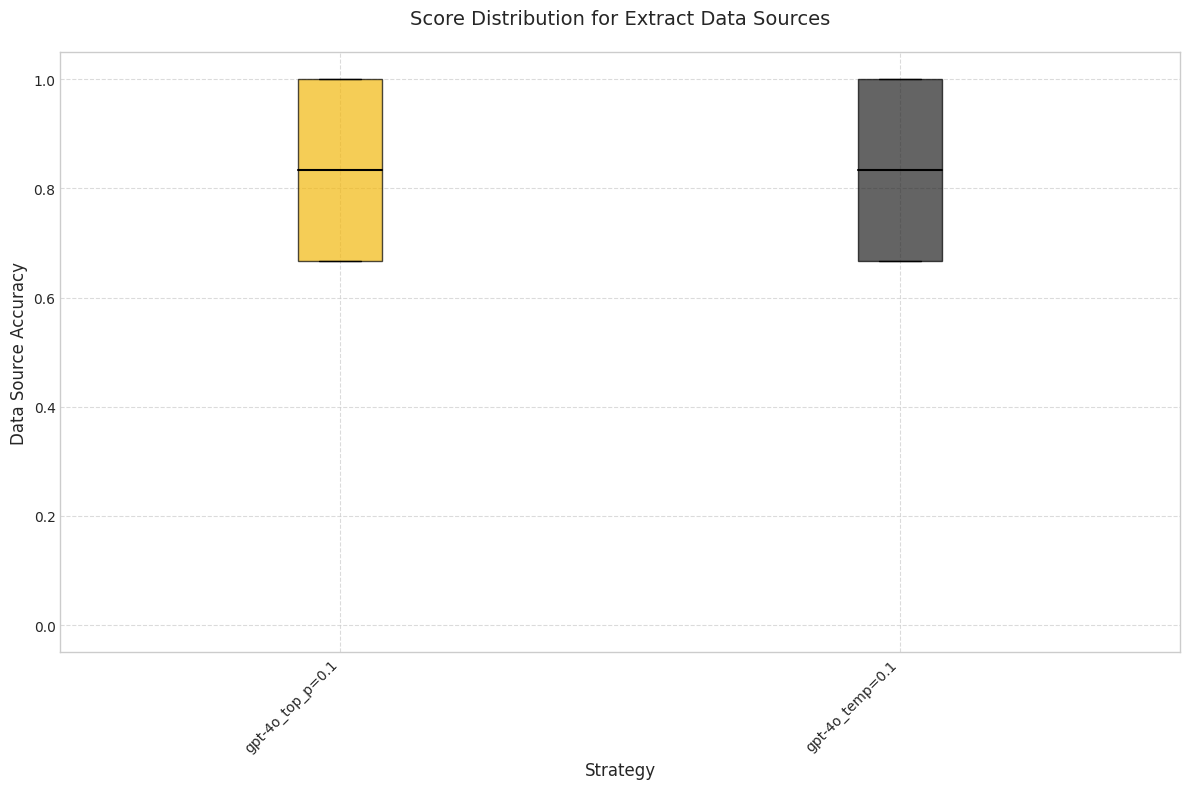

In [ ]:
# Create box plots and get statistics
box_figures = create_boxplots(df, tasks, save_pdf=True)

# Print detailed statistics to understand the data better
print_detailed_statistics(df, tasks)

# Show plots (optional)
plt.show()


# 2. Showing error cases to highlight possible issues

In [ ]:
import difflib
import html
import random
from IPython.display import HTML, display
import pandas as pd

def generate_diff_html(expected: str, actual: str) -> str:
    """
    Generate HTML showing differences between expected and actual text.
    Green for additions, red for deletions.
    """
    # Create a differ object
    differ = difflib.SequenceMatcher(None, expected, actual)
    
    # Generate HTML with highlighted differences
    html_diff = []
    for tag, i1, i2, j1, j2 in differ.get_opcodes():
        if tag == 'equal':
            html_diff.append(html.escape(expected[i1:i2]))
        elif tag == 'delete':
            html_diff.append(f'<span style="background-color: #ffaaaa;">{html.escape(expected[i1:i2])}</span>')
        elif tag == 'insert':
            html_diff.append(f'<span style="background-color: #aaffaa;">{html.escape(actual[j1:j2])}</span>')
        elif tag == 'replace':
            html_diff.append(f'<span style="background-color: #ffaaaa;">{html.escape(expected[i1:i2])}</span>')
            html_diff.append(f'<span style="background-color: #aaffaa;">{html.escape(actual[j1:j2])}</span>')
    
    return ''.join(html_diff)

def show_errors_for_task(df: pd.DataFrame, 
                        task: str, 
                        threshold: float = 0.9, 
                        n_samples: int = 5,
                        seed: int = 42) -> None:
    """
    Display errors for a given task where score is below threshold.
    
    Args:
        df: DataFrame with results
        task: Task to analyze
        threshold: Score threshold below which to show errors
        n_samples: Number of error samples to show
        seed: Random seed for reproducibility
    """
    # Get appropriate score column for task
    score_col = get_score_column(task)
    
    # Filter for the specific task
    task_data = df[df['task'] == task].copy()
    
    # Find errors (scores below threshold)
    errors = task_data[task_data[score_col] < threshold]
    
    if len(errors) == 0:
        print(f"No errors found for task '{task}' below threshold {threshold}")
        return
        
    # Sample errors if we have more than n_samples
    random.seed(seed)
    if len(errors) > n_samples:
        errors = errors.sample(n=n_samples)
    
    # CSS styles for the error display
    css = """
    <style>
    .error-container {
        margin: 20px 0;
        padding: 15px;
        border: 1px solid #ddd;
        border-radius: 5px;
        background-color: white;
    }
    .error-header {
        font-weight: bold;
        margin-bottom: 10px;
        padding-bottom: 5px;
        border-bottom: 1px solid #eee;
        color: #333;
    }
    .error-section {
        margin: 10px 0;
        padding: 10px;
        background-color: #f9f9f9;
        border-radius: 3px;
    }
    .error-label {
        font-weight: bold;
        color: #666;
        margin-bottom: 5px;
    }
    .diff-view {
        font-family: monospace;
        white-space: pre-wrap;
        margin: 10px 0;
        padding: 10px;
        background-color: #fff;
        border: 1px solid #eee;
        line-height: 1.4;
    }
    </style>
    """
    
    # Display total error statistics
    total_errors = len(task_data[task_data[score_col] < threshold])
    total_samples = len(task_data)
    print(f"\nError Analysis for {task}")
    print(f"Total errors (score < {threshold}): {total_errors} / {total_samples} ({total_errors/total_samples*100:.1f}%)")
    print(f"Showing {len(errors)} sample errors\n")
    
    # Create HTML display for each error
    html_output = [css]
    
    for _, row in errors.iterrows():
        error_html = f"""
        <div class="error-container">
            <div class="error-header">
                Strategy: {row['strategy']} | Score: {row[score_col]:.3f}
            </div>
            
            <div class="error-section">
                <div class="error-label">Expected Output:</div>
                <div class="diff-view">{html.escape(row['expected'])}</div>
            </div>
            
            <div class="error-section">
                <div class="error-label">Actual Output:</div>
                <div class="diff-view">{html.escape(row['actual'])}</div>
            </div>
            
            <div class="error-section">
                <div class="error-label">Differences Highlighted:</div>
                <div class="diff-view">{generate_diff_html(row['expected'], row['actual'])}</div>
            </div>
        </div>
        """
        html_output.append(error_html)
    
    # Display the HTML
    display(HTML(''.join(html_output)))


In [ ]:
# Analyze panel source assignment errors
show_errors_for_task(df, 
                     task='panel_source_assignment',
                     threshold=0.9,  # Show examples where score < 0.9
                     n_samples=1)    # Show 5 random examples




Error Analysis for panel_source_assignment
Total errors (score < 0.9): 12 / 12 (100.0%)
Showing 1 sample errors



In [ ]:
# Analyze figure caption extraction errors
show_errors_for_task(df, 
                     task='extract_figure_caption',
                     threshold=0.95,
                     n_samples=1)



Error Analysis for extract_figure_caption
Total errors (score < 0.95): 12 / 168 (7.1%)
Showing 1 sample errors



In [ ]:
show_errors_for_task(df, 
                     task='extract_figure_title',
                     threshold=0.9,  # Show examples where score < 0.9
                     n_samples=1)    # Show 5 random examples




Error Analysis for extract_figure_title
Total errors (score < 0.9): 12 / 84 (14.3%)
Showing 1 sample errors



In [ ]:
show_errors_for_task(df, 
                     task='extract_data_availability_section',
                     threshold=0.9,  # Show examples where score < 0.9
                     n_samples=1)    # Show 5 random examples




Error Analysis for extract_data_availability_section
Total errors (score < 0.9): 6 / 12 (50.0%)
Showing 1 sample errors



In [ ]:
show_errors_for_task(df, 
                     task='extract_data_sources',
                     threshold=0.9,  # Show examples where score < 0.9
                     n_samples=1)    # Show 5 random examples




Error Analysis for extract_data_sources
Total errors (score < 0.9): 6 / 12 (50.0%)
Showing 1 sample errors

